In [46]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm 
from PIL import Image
from torch.utils.data import DataLoader
from matplotlib.colors import TwoSlopeNorm


from crp.image import imgify, vis_opaque_img, plot_grid
#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, get_output_shapes
from crp.cache import ImageCache
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from crp.graph import trace_model_graph
from crp.attribution import AttributionGraph

from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [55]:
from shape_covnet import train_network 
from causal_dsprites_dataset import  BinaryDspritesDataset
from cmiknnmixed import CMIknnMixed
%reload_ext autoreload
%autoreload 2

In [56]:
BATCH_SIZE = 128
BIAS = True

test_unbiased = BinaryDspritesDataset(train=False, with_watermark=True, causal=False)
test_biased = BinaryDspritesDataset(train=False, with_watermark=True, causal=True)

if BIAS:
    dsprites_dataset_train_biased = BinaryDspritesDataset(
        train=True, with_watermark=True, causal=True
    )

    train_biased_loader = DataLoader(
        dsprites_dataset_train_biased, batch_size=BATCH_SIZE, shuffle=True
    )
    model = train_network(
        train_biased_loader,
        BATCH_SIZE,
        load=True,
        path="biased_dsprites_mini.pickle",
        modeltype="mini",
    )
else:
    dsprites_dataset_train_unbiased = BinaryDspritesDataset(
        train=True, with_watermark=True, causal=False
    )

    train_unbiased_loader = DataLoader(
        dsprites_dataset_train_unbiased, batch_size=BATCH_SIZE, shuffle=True
    )
    model = train_network(
        train_unbiased_loader,
        BATCH_SIZE,
        load=False,
        path="unbiased_dsprites_mini.pickle",
        modeltype="mini",
    )

cpu


In [57]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.0, vis_th=0.0, crop_th=0.0)

if BIAS:
    fv_path = "crp-stuff/biased_dsprites_mini"
else:
    fv_path = "crp-stuff/unbiased_dsprites_mini" 
fv = FeatureVisualization(attribution, test_unbiased, layer_map, path=fv_path)

output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

layer_names


['convolutional_layers.0',
 'convolutional_layers.2',
 'linear_layers.0',
 'linear_layers.2']

In [58]:
# RUN REFERENCE IMAGE COMPUTATION
saved_files = fv.run(composite, 0, len(test_unbiased), 20, 100)
layer_id_map

Running Analysis...


100%|██████████| 15000/15000 [05:33<00:00, 45.00it/s]


100%|██████████| 604/604 [00:00<00:00, 2253.83it/s]


{'convolutional_layers.0': array([0, 1, 2]),
 'convolutional_layers.2': array([0, 1, 2]),
 'linear_layers.0': array([0, 1, 2, 3]),
 'linear_layers.2': array([0, 1])}

In [59]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

if BIAS:
    cache = ImageCache(path="biased-cache-mini")
else:
    cache = ImageCache(path="unbiased-cache-mini")

fv = FeatureVisualization(attribution, test_unbiased, layer_map, path=fv_path, cache=cache)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {name: cc for name in layer_names}
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


Layer: convolutional_layers.2


  0%|          | 0/3 [00:00<?, ?it/s]/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
100%|██████████| 3/3 [00:00<00:00, 21.42it/s]


Layer: linear_layers.0


100%|██████████| 4/4 [00:00<00:00, 18.25it/s]


Layer: linear_layers.2


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


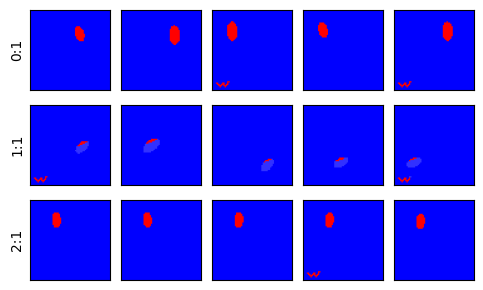

In [17]:
def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.1, vis_th=0.0, crop_th=0.0)

no_ref_samples = 5
def make_all_relevances(cond_layer, neurons):
    all_refs = {}
    for i in neurons:
        targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
        ref_c = fv.get_stats_reference(
            i,
            cond_layer,
            [targets],
            "relevance",
            (0, no_ref_samples),
            composite=composite,
            rf=False,
            plot_fn=vis_simple,
        )
        all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
    plot_grid(all_refs, figsize=(no_ref_samples, len(neurons)), padding=True, symmetric=True)


make_all_relevances("convolutional_layers.0", range(3))

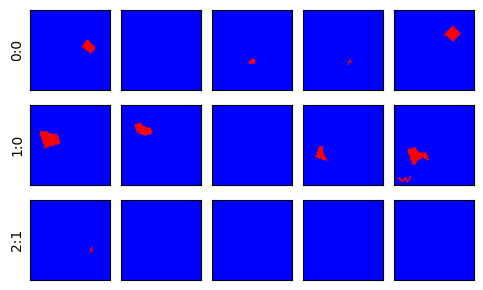

In [61]:
make_all_relevances("convolutional_layers.2",range(3))

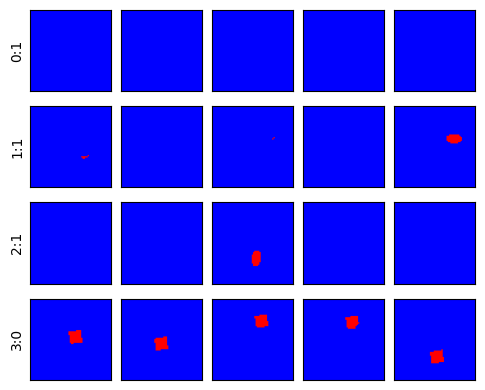

In [62]:
make_all_relevances("linear_layers.0",range(4))

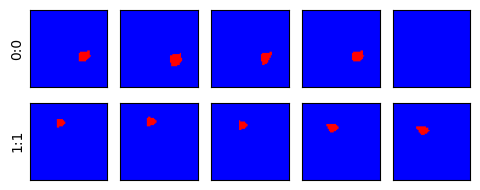

In [63]:
make_all_relevances("linear_layers.2", range(2))

tensor([[-0.4947, -0.0296]])
latents: [ 1  0 27 30  4],
 watermark: 0, 
 prediction:1  
 
 convolutional_layers.0: 
 2: 22.53%, 0: -22.55%, 1: -54.92% 
 
 convolutional_layers.2: 
 2: 83.57%, 1: -2.02%, 0: -14.41% 
 
 linear_layers.0: 
 0: 75.23%, 1: 18.29%, 2: 6.48%, 3: 0.0% 
 
 linear_layers.2: 
 0: 0.0%, 1: -100.0% 


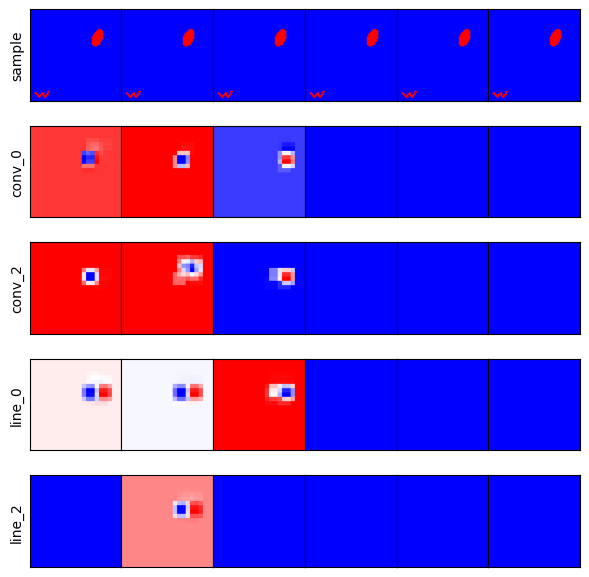

In [87]:
def relevance_for_image(label, image):
    all_refs = {}
    all_refs["sample"] = torch.ones((6,64,64))
    all_refs["sample"][:] = image
    for l in layer_id_map.keys():
        conditions = [{"y": [label], l: [i]} for i in layer_id_map[l]]
        attr = attribution(
            image,
            conditions,
            composite,
            record_layer=layer_names,
        )
        all_refs[f"{l[:4]}_{l[-1]}"] = torch.zeros((6,64,64))
        for h in range(attr.heatmap.shape[0]):
            all_refs[f"{l[:4]}_{l[-1]}"][h] = attr.heatmap[h]

    plot_grid(all_refs, figsize=(6, 6), padding=False)

index = np.random.randint(0, len(test_unbiased))
datum = test_biased[index]
label = datum[1]
img = datum[0]
latents, watermark = test_unbiased.get_item_info(index)
sample = img.view(1, 1, 64, 64)
sample.requires_grad = True
result_string = ""
output = model(sample)
print(output.data)
pred = output.data.max(1, keepdim=True)[1]
res = pred[0][0].tolist()
conditions = [{"y": [res]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
for cond_layer in layer_id_map.keys():
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    # concepts ordered by relevance and their contribution to final classification in percent
    rel_values, concept_ids = torch.topk(rel_c[0], len(layer_id_map[cond_layer]))
    result_string += f'\n \n {cond_layer}: \n {", ".join([str(int(concept_ids[i])) + ": " + str(round(float(rel_values[i])*100, 2)) + "%" for i in range(len(layer_id_map[cond_layer]))])} '
print(
    f'latents: {latents},\n watermark: {watermark}, \n prediction:{res}  {result_string}'
)
relevance_for_image(label, sample)

In [8]:
def make_nn_link_assumptions(layers, same_layer=False, all_factors=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer or (all_factors and layers[l][0] == "0factors"):
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                otherneurons = len(layers[l + 1][1])
                if all_factors and l == 0:
                    otherneurons = sum(len(layers[i][1]) for i in range(1, len(layers)))
                for other_neuron in range(otherneurons):
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "-?>"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "<?-"
                index += 1
    return link_assumptions

In [71]:
sample_size = 100


def sample_from_categories():
    indices = {0: {0: [], 1: []}, 1: {0: [], 1: []}}#, 2: {0: [], 1: []}}
    ds = test_unbiased
    for i in range(sample_size * 28):
        index = np.random.randint(0, len(ds))
        latents, watermark = ds.get_item_info(index)
        label = 0 if latents[0] == 2 else latents[0]
        if len(indices[label][int(watermark)]) < sample_size:
            indices[label][int(watermark)] += [index]
    return indices


indices = sample_from_categories()
print([len(indices[i][j]) for i in range(2) for j in range(2)])

[100, 100, 100, 100]


In [72]:
def draw_graph(nodes, connections, ax=None):
    edges = [
        (
            i,
            j,
            dict(
                weight=connections[i][j],
                label=(
                    str(round(connections[i][j], 3))
                    if np.abs(connections[i][j]) >= 0.01
                    else ""
                ),
            ),
        )
        for i in connections.keys()
        for j in connections[i].keys()
        if connections[i][j] != 0
    ]
    edges = sorted(edges)
    nodes = sorted(nodes)
    subsets = {i: i[0:-2] for i in nodes}

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    weights = {(i, j): l for i, j, l in G.edges.data("weight")}
    labels = {(i, j): l for i, j, l in G.edges.data("label")}
    colors = np.array(list(weights.values()), dtype=np.float64)
    norm = TwoSlopeNorm(vcenter=-0.0)
    colors = norm(colors)

    for n in G.nodes:
        if n[0] not in ["c", "l"]:
            G.nodes[n]["subset"] = "pred"
        else:
            G.nodes[n]["subset"] = subsets[n]
    pos = nx.multipartite_layout(G, subset_key="subset")
    if ax is None:
        fig = plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        node_size=1000,
        linewidths=0,
        width=5,
        node_color="#bbb",
        node_shape="s",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.coolwarm,
        edge_color=colors,
        connectionstyle="arc,rad=0.1",
        with_labels=False,
    )
    nx.draw_networkx_edge_labels(
        G,
        ax=ax,
        pos=pos,
        edge_labels=labels,
        label_pos=0.35,
        clip_on=False,
        verticalalignment="baseline",
        bbox={"fc": "white", "alpha": 0.0, "ec": "white"},
    )
    nx.draw_networkx_labels(
        G, ax=ax, pos=pos, font_size=14, bbox={"ec": "#555", "fc": "#bbb", "alpha": 0.5}
    )

In [73]:
def make_relevance_graph(ds, index):
    names = {
        "linear_layers.2_0": "A_rectangle",
        "linear_layers.2_1": "1_ellipse",
        "linear_layers.2_2": "2_heart",
    }
    img, _ = ds[index]
    sample = img.view(1, 1, 64, 64)
    with torch.no_grad():
        output = model(sample)
        pred = int(output.data.max(1)[1][0])
    sample.requires_grad = True

    graph = trace_model_graph(model, sample, layer_names)
    attgraph = AttributionGraph(attribution, graph, layer_map)
    nodes, connections = attgraph(
        sample,
        composite,
        pred,
        "linear_layers.2",
        width=[6, 6, 6],
        abs_norm=True,
        verbose=False,
        batch_size=1,
    )
    edges = {}
    for i in connections.keys():
        name = (
            names[f"{i[0]}_{i[1]}"] if f"{i[0]}_{i[1]}" in names else f"{i[0]}_{i[1]}"
        )
        edges[name] = {f"{j[0]}_{j[1]}": j[2] for j in connections[i]}

    node_labels = [
        names[f"{i[0]}_{i[1]}"] if f"{i[0]}_{i[1]}" in names else f"{i[0]}_{i[1]}"
        for i in nodes
    ]
    return node_labels, edges

In [74]:
def average_hierarchies(indices):
    relevance_graphs = {
        0: {0: {}, 1: {}},
        1: {0: {}, 1: {}},
        2: {0: {}, 1: {}},
        "nodes": set(),
    }
    cluster_data = {}
    ds = test_unbiased
    for l in indices.keys():
        for w in indices[l].keys():
            for i in range(len(indices[l][w])):
                nodes, edges = make_relevance_graph(ds, indices[l][w][i])
                relevance_graphs["nodes"].update(nodes)
                for s in edges.keys():
                    if s not in relevance_graphs[l][w]:
                        relevance_graphs[l][w][s] = {}
                    for t in edges[s].keys():
                        val = edges[s][t] / sample_size
                        if (s,t) not in cluster_data:
                            cluster_data[(s,t)] = [val]
                        else:
                            cluster_data[(s,t)] += [val]
                        if val != 0:
                            if t not in relevance_graphs[l][w][s]:
                                relevance_graphs[l][w][s][t] = val
                            else:
                                relevance_graphs[l][w][s][t] += val
    return relevance_graphs, cluster_data

In [75]:
rele, cluster_data = average_hierarchies(indices)
#values = [rele[i][j][n][sub] for i in [0,1,2] for j in [0,1]  for n in rele[i][j].keys() for sub in rele[i][j][n]]
#values = np.array(values).flatten()
#min_relevance = min(values)
#max_relevance= max(values)

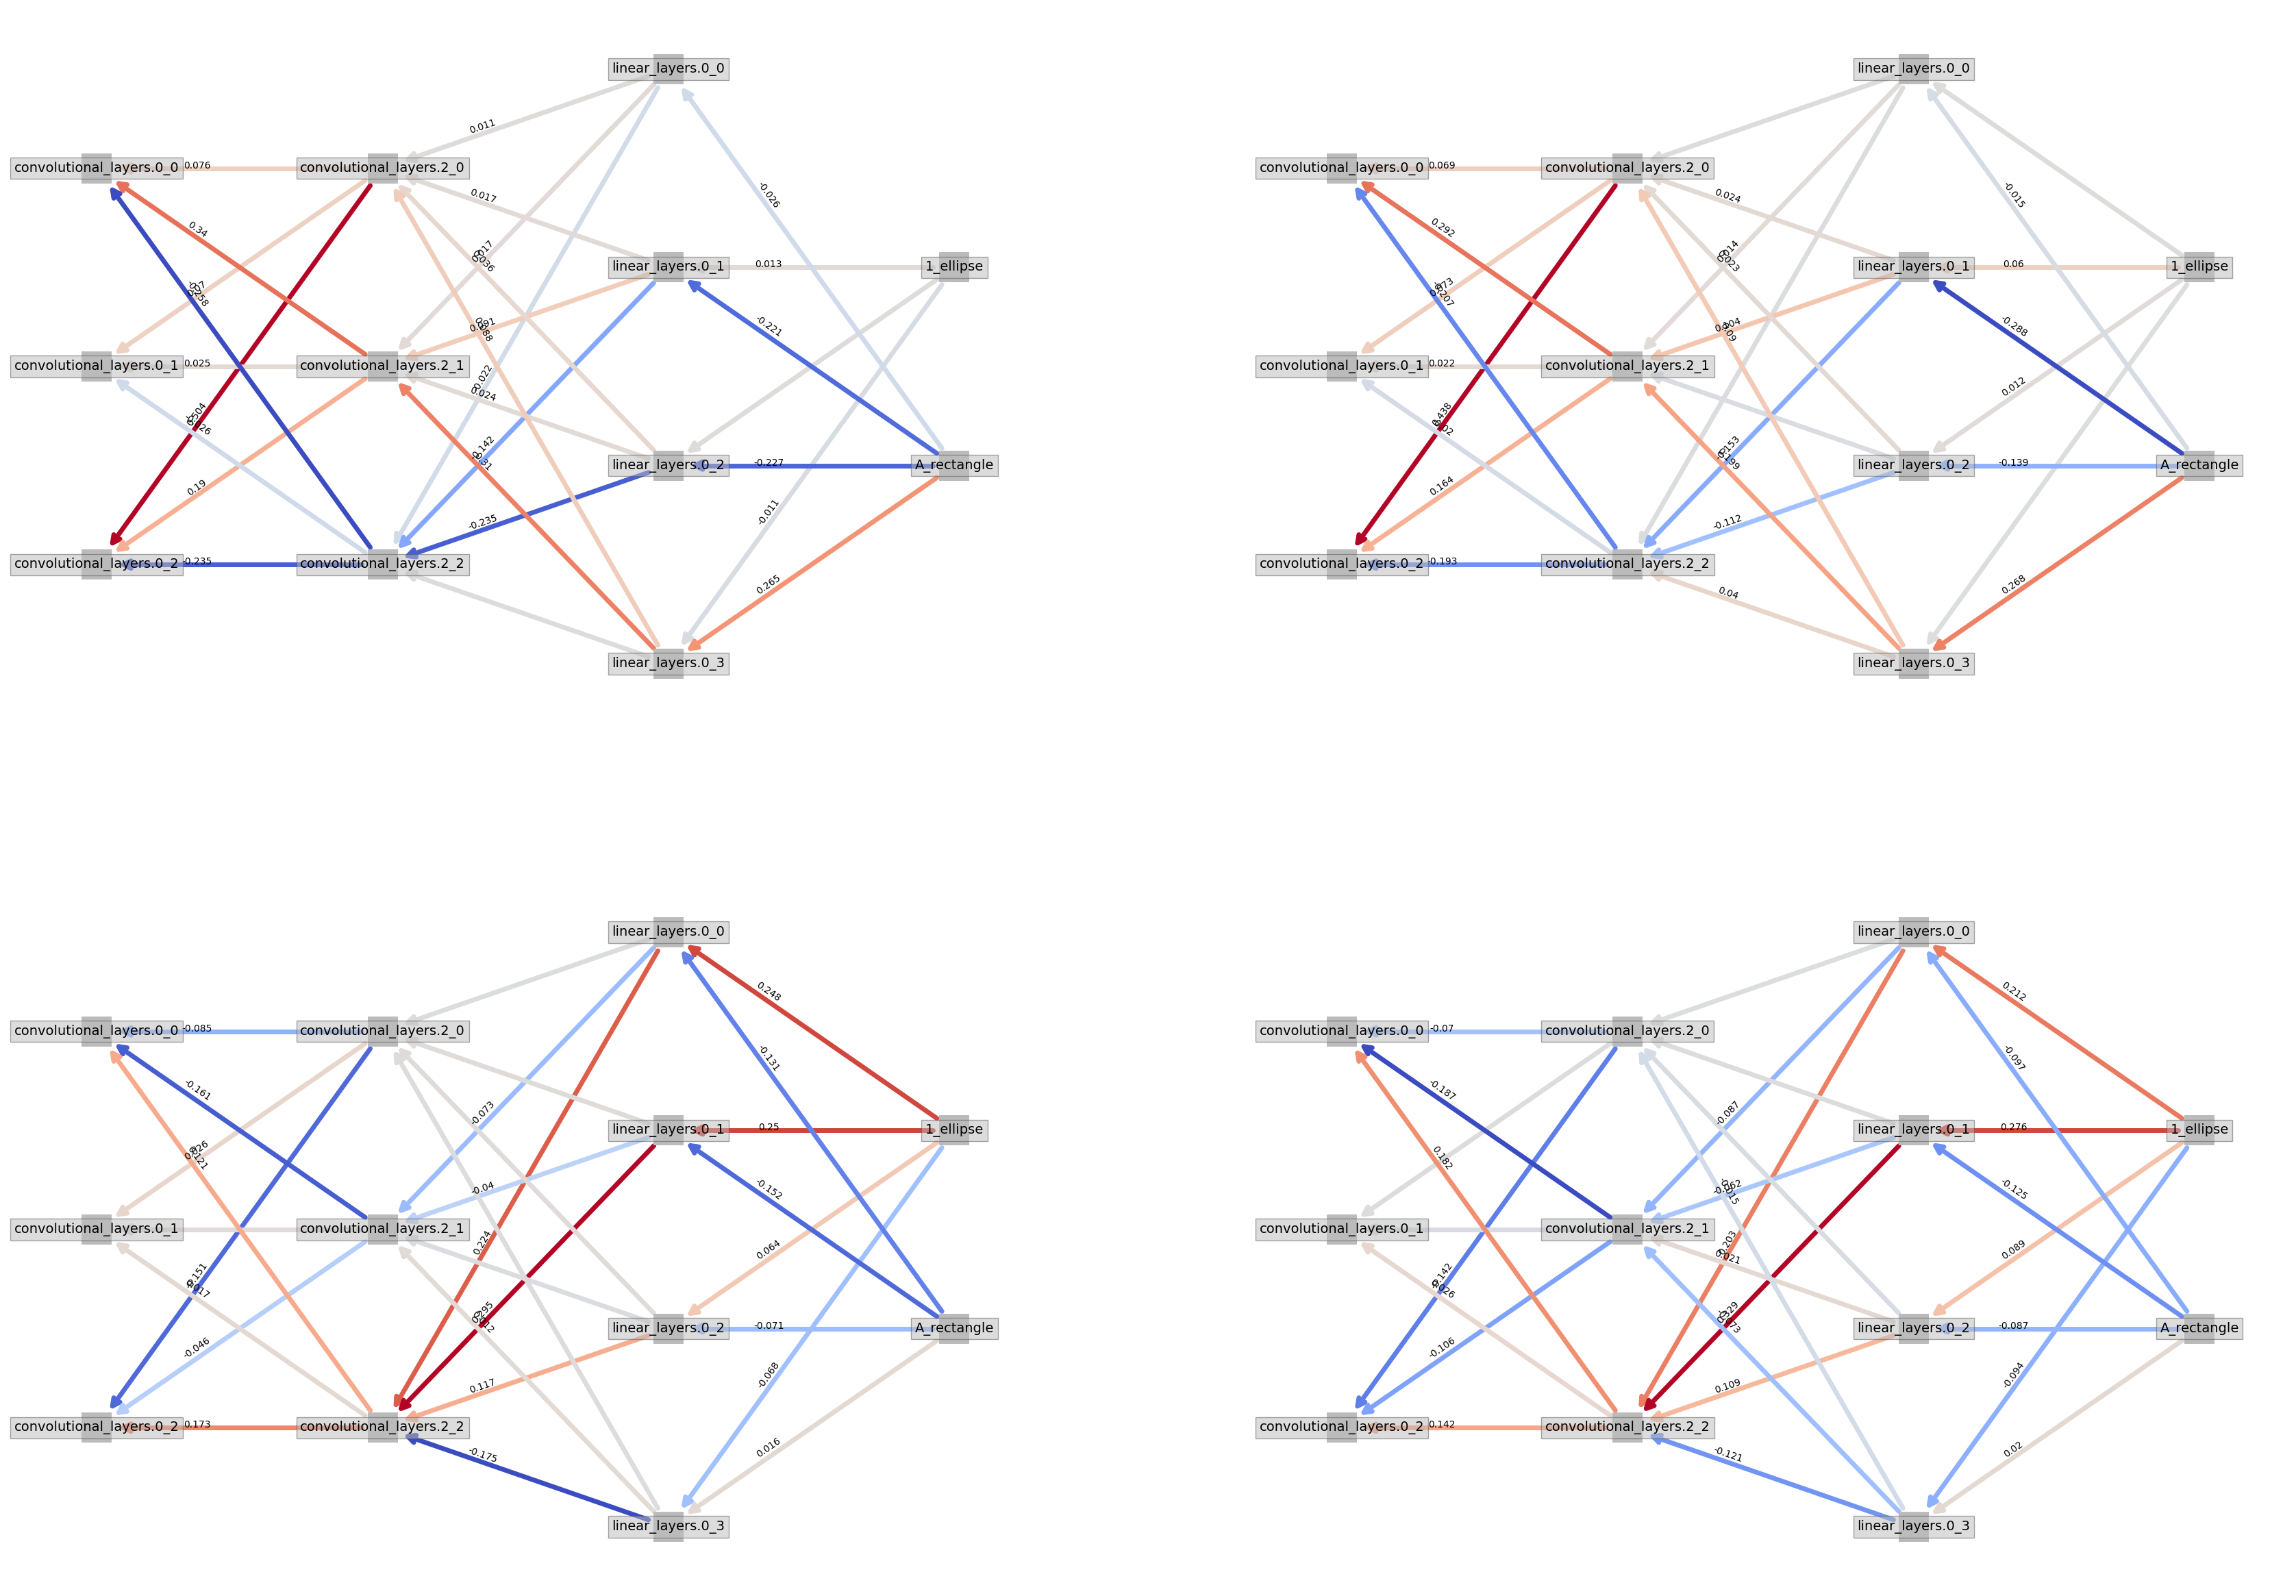

In [77]:
fig = plt.figure(figsize=(43, 30))

ax0 = fig.add_subplot(221, frame_on=False)
ax1 = fig.add_subplot(222, frame_on=False)
ax2 = fig.add_subplot(223, frame_on=False)
ax3 = fig.add_subplot(224, frame_on=False)
draw_graph(list(rele["nodes"]), rele[0][0], ax0)
draw_graph(list(rele["nodes"]), rele[0][1], ax1)
draw_graph(list(rele["nodes"]), rele[1][0], ax2)
draw_graph(list(rele["nodes"]), rele[1][1], ax3)

In [94]:
def activations_for_indices(indices):
    act_data = np.zeros((sample_size, 21))
    activations_data = {
        0: {0: act_data, 1: act_data},
        1: {0: act_data, 1: act_data},
        2: {0: act_data, 1: act_data},
    }
    dfs = []
    one_df = np.zeros((sample_size * 6, 21))
    ds = test_unbiased
    var_names = [
        f"{l}_{i}" for l in layer_id_map.keys() for i in layer_id_map[l]
    ]  # ["A_scale", "A_rot", "A_posX", "A_posY"] +
    count = 0
    for l in indices.keys():
        for w in indices[l].keys():
            for i in range(len(indices[l][w])):
                index = indices[l][w][i]
                img, _ = ds[index]
                # latents, _ = ds.get_item_info(index)
                # latents = latents / ds.latents_sizes[1:]
                sample = img.view(1, 1, 64, 64)
                with torch.no_grad():
                    output = model(sample)
                    pred = int(output.data.max(1)[1][0])
                sample.requires_grad = True
                conditions = [{"y": [pred]}]
                attr = attribution(
                    sample, conditions, composite, record_layer=layer_names
                )
                relc = [
                    cc.attribute(attr.relevances[l], abs_norm=True) #activations
                    for l in layer_names
                ]
                blub = [
                    float(relc[l][0][i])  # / (1 + latents[1])
                    for l in range(len(layer_id_map.keys()))
                    for i in range(len(relc[l][0]))
                ]
                # activations_data[l][w][i][:4] = latents[1:]
                values = np.array(blub, dtype=np.float64)
                activations_data[l][w][i] = values
                one_df[count] = values
                count += 1
            # types = np.zeros(activations_data[l][w].shape, dtype="int")
            # types[:, :4] = 1  # , data_type=types)
            # dataframe = pp.DataFrame(activations_data[l][w], var_names=var_names)
            # dfs += [dataframe]
    dfs = pp.DataFrame(one_df, var_names=var_names)
    return [dfs]


dataframes = activations_for_indices(indices)

In [95]:
def causal_graph_to_nx(graph_res, layers):
    value_matrix = np.copy(graph_res["val_matrix"])
    graph_matrix = np.copy(graph_res["graph"])
    value_matrix[:, :, 0] = np.triu(value_matrix[:, :, 0])
    graph_matrix[:, :, 0] = np.triu(graph_matrix[:, :, 0])
    not_null = np.where(graph_matrix =="")
    edges = {layers[i]: {layers[j]: value_matrix[i,j,0] for j in not_null[1]} for i in not_null[0]}
    return edges

In [98]:
# ci_test = CMIknnMixed(significance="fixed_thres", fixed_thres=0.1)
ci_test = RobustParCorr(significance="analytic")
#ci_test = CMIknn(significance="fixed_thres", fixed_thres=0.1)
layers = [[l, layer_id_map[l]] for l in layer_id_map.keys()]
# [["0factors", ["A_scale", "A_rot", "A_posX", "A_posY"]]] +
link_assumptions = make_nn_link_assumptions(layers)
print(link_assumptions)
graphs = []
for dataframe in dataframes:
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
    results = pcmci.run_pcmciplus(
        tau_max=0, pc_alpha=0.01, link_assumptions=link_assumptions
    )
    graph = causal_graph_to_nx(results, dataframe.var_names)
    graphs += [graph]

{0: {(6, 0): '-?>', (7, 0): '-?>', (8, 0): '-?>', (9, 0): '-?>', (10, 0): '-?>', (11, 0): '-?>'}, 6: {(0, 0): '<?-', (1, 0): '<?-', (2, 0): '<?-', (3, 0): '<?-', (4, 0): '<?-', (5, 0): '<?-', (12, 0): '-?>', (13, 0): '-?>', (14, 0): '-?>', (15, 0): '-?>', (16, 0): '-?>', (17, 0): '-?>'}, 7: {(0, 0): '<?-', (1, 0): '<?-', (2, 0): '<?-', (3, 0): '<?-', (4, 0): '<?-', (5, 0): '<?-', (12, 0): '-?>', (13, 0): '-?>', (14, 0): '-?>', (15, 0): '-?>', (16, 0): '-?>', (17, 0): '-?>'}, 8: {(0, 0): '<?-', (1, 0): '<?-', (2, 0): '<?-', (3, 0): '<?-', (4, 0): '<?-', (5, 0): '<?-', (12, 0): '-?>', (13, 0): '-?>', (14, 0): '-?>', (15, 0): '-?>', (16, 0): '-?>', (17, 0): '-?>'}, 9: {(0, 0): '<?-', (1, 0): '<?-', (2, 0): '<?-', (3, 0): '<?-', (4, 0): '<?-', (5, 0): '<?-', (12, 0): '-?>', (13, 0): '-?>', (14, 0): '-?>', (15, 0): '-?>', (16, 0): '-?>', (17, 0): '-?>'}, 10: {(0, 0): '<?-', (1, 0): '<?-', (2, 0): '<?-', (3, 0): '<?-', (4, 0): '<?-', (5, 0): '<?-', (12, 0): '-?>', (13, 0): '-?>', (14, 0): '-

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/tigramite-5.2.1.16-py3.10.egg/tigramite/independence_tests/robust_parcorr.py:170: UserWarning: Possibly constant array!
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


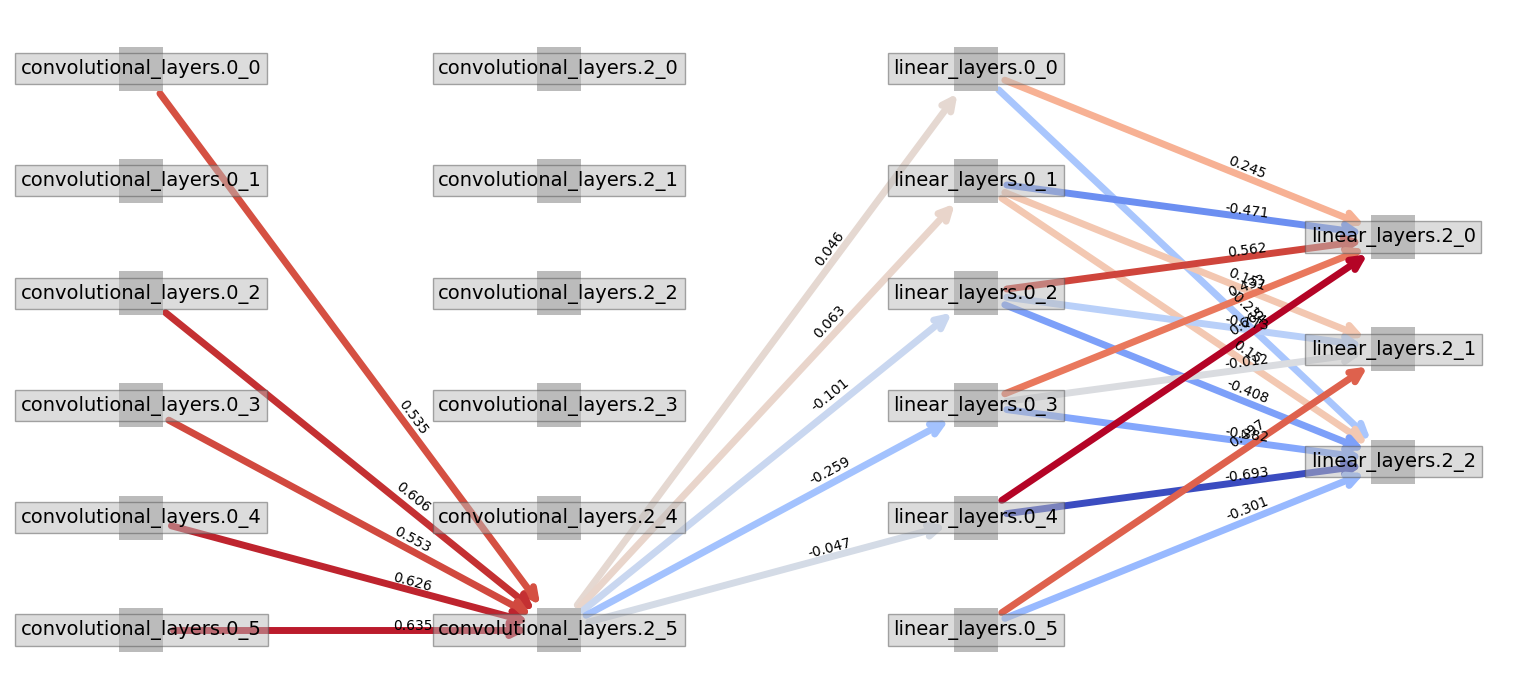

In [99]:

fig = plt.figure(figsize=(43, 30))
i = 0
for edges in graphs:
    ax = fig.add_subplot(3,2,i+1, frame_on=False)
    draw_graph(dataframe.var_names, edges, ax)
    i+=1

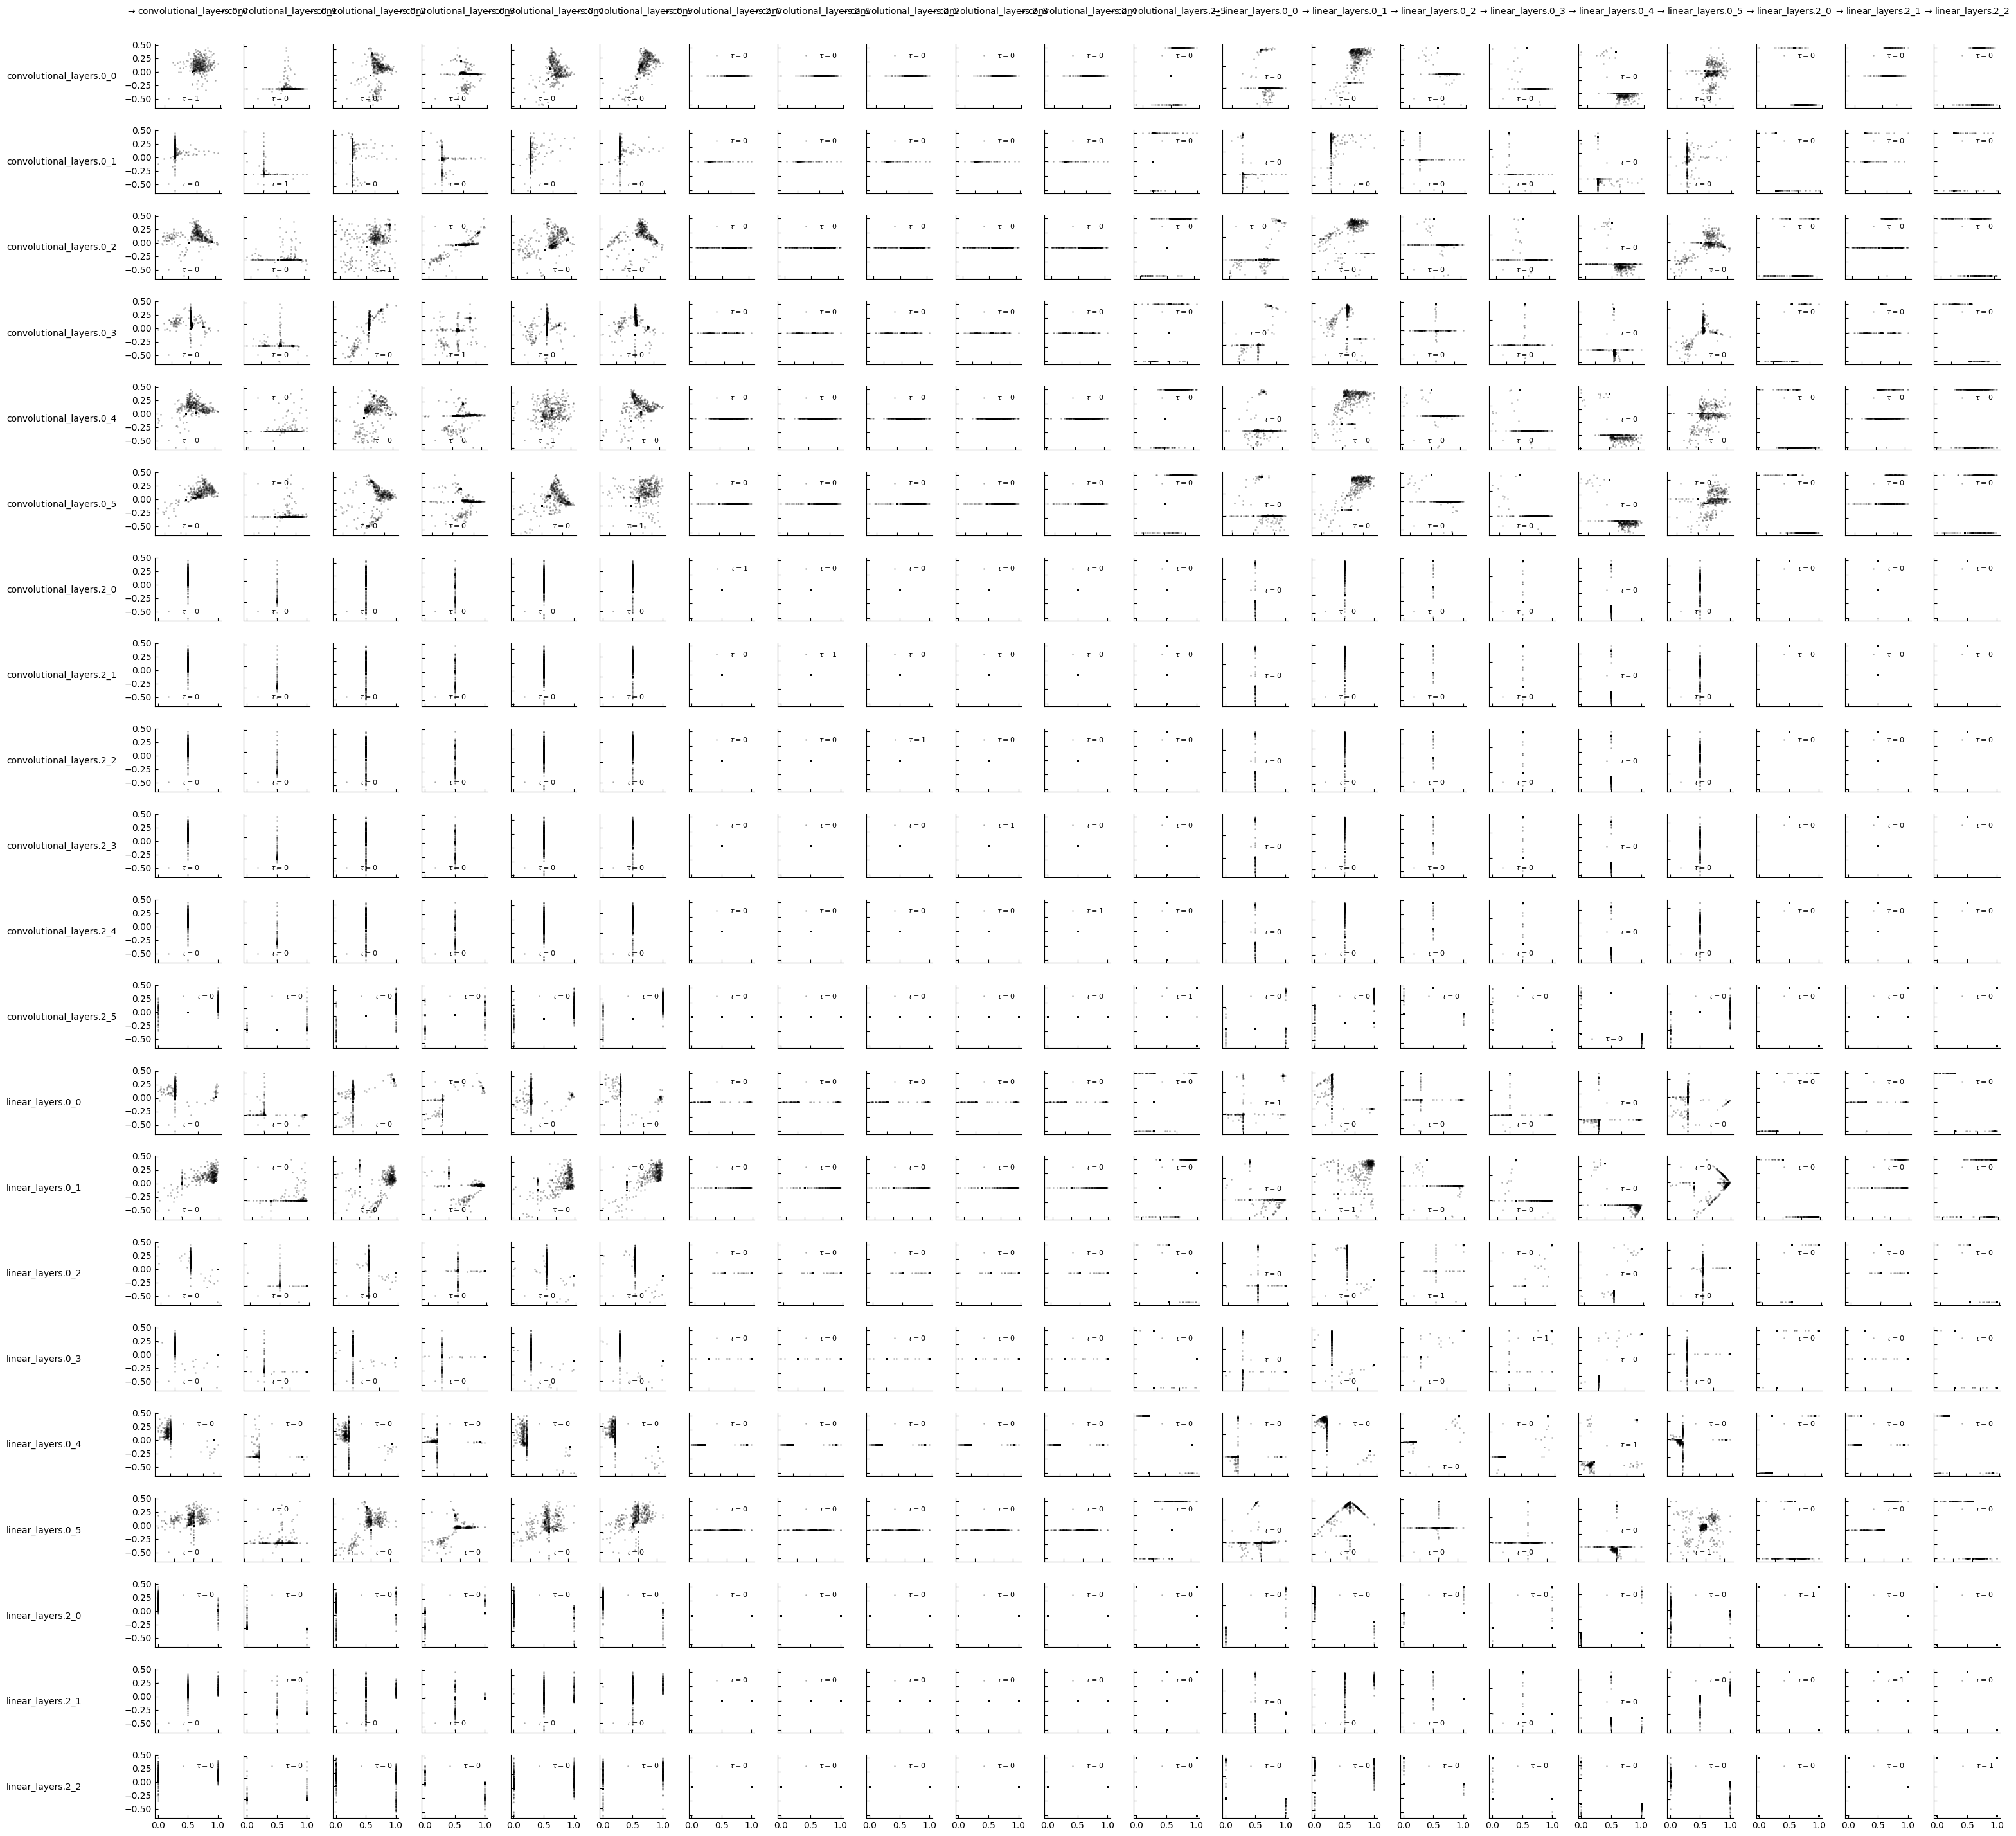

In [100]:
setup_args = {"figsize": (33,30),"label_space_left": 0.08,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [159]:
import json
with open("hierarchies_unbiased.json", "+w") as f:
    rele["nodes"] = list(rele["nodes"])
    json.dump(rele, f)

In [ ]:
# new stuff learned from tutorial:


# using different initialization instead of normal output value
softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    #print(mask, mask.shape)
    return mask

conditions = [{"features.40": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite, init_rel=select_max)
imgify(heatmap, symmetric=True)




# use mask to only look at whats important inside it
mask = torch.zeros(224, 224).to(attribution.device)
mask[:, 180:] = 1

imgify(mask, symmetric=True)

# use generate to speed up computation
conditions = [{'features.40': [id], 'y': [46]} for id in torch.arange(0, 512)]

from crp.helper import abs_norm

rel_c = []
for attr in attribution.generate(sample, conditions, composite, record_layer=layer_names, batch_size=10):
    
    masked = attr.heatmap * mask[None, :, :]
    rel_c.append(torch.sum(masked, dim=(1, 2)))

rel_c = torch.cat(rel_c)

indices = torch.topk(rel_c, 5).indices
# we norm here, so that we clearly see the contribution inside the masked region as percentage
indices, abs_norm(rel_c)[indices]*100